In [199]:
# QUANTIFY RESULTS!  B A M 
from GLD_file_tools import GLD_file_tools
from satellite import Satellite
import datetime
import ephem
from coordinate_structure import coordinate_structure
from coordinate_structure import transform_coords
from longitude_scaling import longitude_scaling
#from ionoAbsorp import ionoAbsorp
import os
from mpl_toolkits.basemap import Basemap
from precip_model import precip_model
from measurement_model import measurement_model
import itertools
import random
import matplotlib.tri as mtri
import matplotlib as mpl
from fluxMDP import get_map_scaling, get_time_scaling
from coordinate_structure import coordinate_structure
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 2.6 #fig_width_pt*inches_per_pt  # width in inches
fig_height = 2.7 #fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size,        
          'figure.autolayout': True}
#           'figure.subplot.left': 0.2,
#           'figure.subplot.bottom':0.2,
#           'figure.subplot.top':0.995,
#           'figure.subplot.right':0.95}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [9]:
# Full database (for naive approach):
with open('/Users/austin/FUSE2/shared/users/asousa/WIPP/fluxMDP/outputs/complete_filled_measurements.pkl','rb') as file:
    full_db = pickle.load(file)

In [3]:
# Load training history ---------------------------------
def load_history(filepath):
    d = dict()
    datafiles = []

    for root, dirs, files in os.walk(filepath):
        for f in files:
            if f.startswith('data_i'):
                datafiles.append(f)
                with open(os.path.join(root,f),'rb') as p:
                    data = pickle.load(p)
                    for row in data:
                        #print row
    #                     d[row[0][3]][row[0][2]] = row[1]
                        timestamp = row[0][1]
                        meas_type = row[0][2]
                        data = row[1]
                        if not timestamp in d:
                            d[timestamp] = dict()
                        if meas_type in d[timestamp]:
                            if not d[timestamp][meas_type] == data:
                                print "Mismatch!" + timestamp + meas_type
    #                    d[row[0][2]][row[0][3]] = row[1]
                        d[timestamp][meas_type] = data
    print "loaded %g entries" % len(d.keys())
    
    return d
# -------------------------------------------------------




In [6]:
def data_usage(action):
    if action=='continuous':
        return 1
    elif action == 'low':
        return 1.0/4.0
    elif action == 'mid':
        return 1.0/8.0
    elif action == 'high':
        return 1.0/8.0
    elif action == 'off':
        return 0.0
    

# run to load:
root_dir = '/Users/austin/FUSE2/shared/users/asousa/WIPP/fluxMDP/outputs/random_runs/'
runs = os.listdir(root_dir)

all_scores = dict()

for run_ind, run in enumerate(runs):
# run_ind = 0
# run = 'run_MGOG0T'

    if not run in all_scores.keys():
        try:
            print "loading %s (%g of %g )"% (run, run_ind, len(runs))
            d = load_history(os.path.join(root_dir, run))

            keys = sorted(d.keys())
            starttime = datetime.datetime(2015,11,3,0,0,0)
            start_key = keys.index(starttime)

            detector_size = 1000

            measurements = []
            data_used = []

            times = keys[start_key:-1]
            #times = keys

            for k in times:
                action = d[k].keys()[0]
                #print action
                measurements.append(detector_size*d[k][action])
            #     if data_usage(action) is None:
            #         print "HEY! :",action
                data_used.append(data_usage(action))

            score = np.cumsum(measurements)/np.maximum(1,np.cumsum(data_used))

#            all_scores[run] = score
            all_scores[run] = dict()
            all_scores[run]['scores'] = score
            all_scores[run]['measurements'] = measurements
            all_scores[run]['data_used'] = data_used
        except:
            print "Failed on %s"%run

    
with open('all_scores_with_measurements.pkl','wb') as file:
    pickle.dump(all_scores,file)


loading run_QLSO2P (0 of 300 )
loaded 96570 entries
loading run_U320DC (1 of 300 )
loaded 96570 entries
loading run_ZZ90M2 (2 of 300 )
loaded 96570 entries
loading run_3G9Y8E (3 of 300 )
loaded 96570 entries
loading run_MGOG0T (4 of 300 )
loaded 96570 entries
loading run_DAN7E7 (5 of 300 )
loaded 96570 entries
loading run_YNPX82 (6 of 300 )
loaded 96570 entries
loading run_2TYSA2 (7 of 300 )
loaded 96570 entries
loading run_BG67LO (8 of 300 )
loaded 96570 entries
loading run_NA0X8M (9 of 300 )
loaded 96570 entries
loading run_U98TPZ (10 of 300 )
loaded 96570 entries
loading run_D7EFQG (11 of 300 )
loaded 96570 entries
loading run_MDI6PR (12 of 300 )
loaded 96570 entries
loading run_DFN1QA (13 of 300 )
loaded 96570 entries
loading run_D41GAX (14 of 300 )
loaded 96570 entries
loading run_95OKWV (15 of 300 )
loaded 96570 entries
loading run_62MIWL (16 of 300 )
loaded 96570 entries
loading run_NMBC2J (17 of 300 )
loaded 96570 entries
loading run_NGPP0S (18 of 300 )
loaded 96570 entries
loa

In [20]:
# Naive approach:

sat_TLE  = ["1 40378U 15003C   15293.75287141  .00010129  00000-0  48835-3 0  9990",
            "2 40378  99.1043 350.5299 0153633 201.4233 158.0516 15.09095095 39471"]

# Satellite object:
sat = Satellite(sat_TLE[0], sat_TLE[1],'Firebird 4')


lat_min = 30
lat_max = 70

naive_measurements = []
naive_data_used = []

for k in times:
    sat.compute(k)
    sat.coords.transform_to('geomagnetic')

    # Pick action:
    if (sat.coords.lat() > lat_min) and (sat.coords.lat() < lat_max):
        action = 'continuous'
    else:
        action = 'off'

    naive_measurements.append(detector_size*full_db[k][action])
    naive_data_used.append(data_usage(action))

naive_score = np.cumsum(naive_measurements)/np.maximum(1,np.cumsum(naive_data_used))
naive_score_diff = np.cumsum(naive_measurements) - np.cumsum(naive_data_used)


(0, 3)

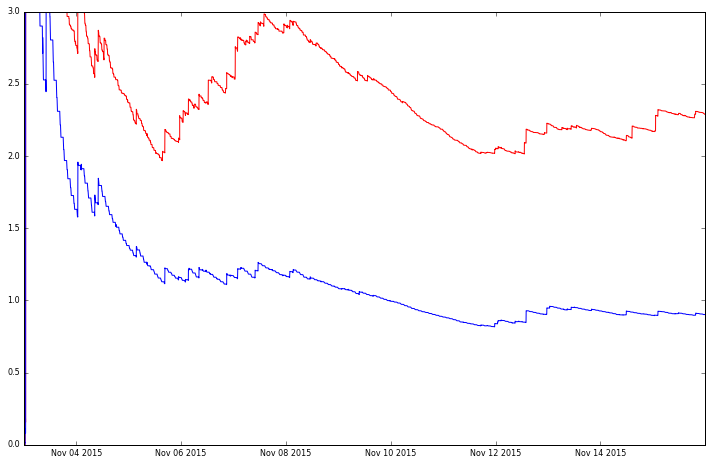

In [11]:
f,ax = plt.subplots(1,1)
ax.plot(times,score,'r')
ax.plot(times,naive_score,'b')
ax.set_ylim([0,3])


148
148
(37439,)


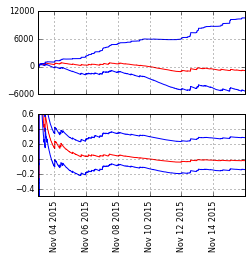

In [202]:
end_vals_diff  = []
end_vals_ratio = []
keys = sorted(all_scores.keys())
for k in keys:
    end_vals_diff.append(all_scores[k]['score_diff'][-1])
    end_vals_ratio.append(all_scores[k]['scores'][-1])
    #ax.plot(all_scores[k],color='b',marker='.',alpha=0.5)

indmax = np.argmax(end_vals_diff)
indmin = np.argmin(end_vals_diff) 

times = np.array(times)
l = len(all_scores[keys[indmax]]['score_diff'])
den = np.linspace(1,l,l)
#den = 1
f,ax = plt.subplots(2,1)

print np.argmax(end_vals_diff)
print np.argmax(end_vals_ratio)

ax[0].plot(times, naive_score_diff,'r')
ax[0].plot(times, all_scores[keys[indmax]]['score_diff'],'b')
ax[0].plot(times, all_scores[keys[indmin]]['score_diff'],'b')
plt.setp(ax[0].get_xticklabels(),visible=False)
ax[0].set_yticks(np.linspace(-6000,12000,4))
ax[0].grid('on')
#ax[0].set_ylim([-1,1])
ax[1].plot(times, naive_score_diff/den,'r')
ax[1].plot(times, all_scores[keys[indmax]]['score_diff']/den,'b')
ax[1].plot(times, all_scores[keys[indmin]]['score_diff']/den,'b')
ax[1].set_ylim([-0.5,0.6])
ax[1].grid('on')
plt.xticks(rotation='vertical')
plt.savefig('training.png',dpi=300)



print np.shape(all_scores[keys[indmax]]['score_diff'])

In [16]:
# Add diff score to each entry
keys = sorted(all_scores.keys())
for k in keys:
    all_scores[k]['score_diff'] = np.cumsum(all_scores[k]['measurements']) - np.cumsum(all_scores[k]['data_used'])
    
# Load coefficients for all runs:
for k in keys:
    with open(os.path.join(root_dir,k,'odb.pkl'),'rb') as file:
        all_scores[k]['parameters'] = pickle.load(file)



148
(298,)
(298,)
[28, 95, 23, 49, 243, 211, 121, 212, 182, 148]


run_IBK9PL


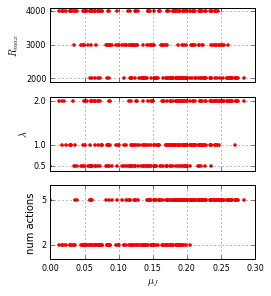

In [164]:
key_inds_sorted = [i[0] for i in sorted(enumerate(end_vals_diff), key=lambda x:x[1])]

print indmax
print np.shape(key_inds_sorted)
print np.shape(end_vals_diff)
print key_inds_sorted[-10:]
#plt.plot([end_vals_diff[f] for f in key_inds_sorted])
#print [keys[f] for f in key_inds_sorted[-10:]]


evx = [end_vals_diff[f] for f in key_inds_sorted]
evx = np.array(evx) / np.size(all_scores[keys[indmax]]['score_diff'])


f,ax = plt.subplots(3,1)
ax[0].plot(evx,[all_scores[keys[f]]['parameters']['smoothing_radius'] for f in key_inds_sorted],'r.')
ax[0].set_ylabel('$R_{max}$')
ax[0].set_yticks([2000,3000,4000])
ax[0].set_ylim([1900,4100])

ax[1].plot(evx,[all_scores[keys[f]]['parameters']['storage_penalty'] for f in key_inds_sorted],'r.')
ax[1].set_ylabel('$\lambda$')
ax[1].set_ylim([0.4,2.1])
ax[1].set_yticks([0.5, 1, 2])

ax[2].plot(evx,[len(all_scores[keys[f]]['parameters']['gActs']) for f in key_inds_sorted],'r.')
ax[2].set_ylabel('num actions')
ax[2].set_ylim([1,6])
ax[2].set_yticks([2,5])
ax[2].set_xlabel('$\mu_f$')


plt.setp([a.get_xticklabels() for a in ax[0:-1]], visible=False)
plt.setp([a.grid('on') for a in ax])
plt.setp([a.set_xlim([0,0.3]) for a in ax])

plt.savefig('parameters.png',dpi=300)

# ax[4].plot([all_scores[keys[f]]['parameters']['num_times'] for f in key_inds_sorted],'.-')
# ax[4].set_ylabel('num times')

# ax[5].plot([all_scores[keys[f]]['parameters']['alpha'] for f in key_inds_sorted],'.-')
# ax[5].set_ylabel('$\alpha$')

# ax[6].plot([all_scores[keys[f]]['parameters']['gamma'] for f in key_inds_sorted],'.-')
# ax[6].set_ylabel('$\gamma$')

# ax[1].plot([all_scores[keys[f]]['parameters']['switching_penalty'] for f in key_inds_sorted],'.-')
# ax[1].set_ylabel('$\kappa$')

print keys[indmax]


In [168]:
np.array(times)

array([datetime.datetime(2015, 11, 3, 0, 0),
       datetime.datetime(2015, 11, 3, 0, 0, 30),
       datetime.datetime(2015, 11, 3, 0, 1), ...,
       datetime.datetime(2015, 11, 15, 23, 58),
       datetime.datetime(2015, 11, 15, 23, 58, 30),
       datetime.datetime(2015, 11, 15, 23, 59)], dtype=object)